In [1]:
# required stuff
import sys
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/thermal')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/aqueous')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/transport')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/rock')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/tables')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/plotting')
import matplotlib.pyplot as plt
import numpy as np

# 1). Import WOW!

In [2]:
# import WOW (WOW! Ocean Worlds)
import WOW

# 2). Create model grid

In [3]:
######### define grid ##############

nr = 101       # Number of radii
maxnt = 200  # Maximum number of time steps

YR = 3.1536E7            #(Year to seconds conversion)
StartTime=2.6*10**6*YR   # Myrs
EndTime = 4567*10**6*YR  # Myrs. Stop time if maxnt is not reached Myr
Radius = 480000          # meters

# parameters for perplex grid
temp_step = 25 # how many degrees temperature difference before recalculating thermal properties? 
press_step= 10 # how many radius points between each perplex equilibration calculation

Ceres = WOW.Planet(nr,StartTime,EndTime,Radius,maxnt,temp_step,press_step)

# 3). Initialize model composition

### 3a starting temperature

In [4]:
# Starting temperature
init_Temp = 100

### 3b starting bulk composition

In [5]:
########### initialize comp ############

# Starting composition (Mass fraction of ice and rock must sum to 1)
ICE_frac=0.25
#OrgFrac=0.20
OrgFrac=0.02 # percentage of rock that is organics

# Ice composition
# Ci
init_IceComp={'H2O':99.0,'C':0.272,'O':0.728} #,'CO':0,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}
#init_IceComp={'H2O':100.0,'CO2':0.0,'NH3':0.0,'CH4':0.0} #,'CO':0,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}
# Comet
#init_IceComp={'H2O':62.5,'CO2':30.0,'NH3':5.0,'CH4':2.5}#,'CO':12.5}#,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}

# Rock composition
#init_RockComp={"H":3.333,"C":0.00,"Mg":32.6277,"Al":0.00,"Si":15.5176,"S":0.00,"Ca":0.00,"Fe":5.0295,"O":43.4922,"Na":0.00,"N":0.00}
#init_RockComp={"H":3.93,"C":57.26,"Mg":1.55,"Al":0.28,"Si":16.41,"S":1.20,"Ca":0.13,"Fe":9.49,"O":57.26,"Na":1.09,"N":0.35}

# Comet dust
#init_RockComp={"H":2.547,"C":30.589,"Mg":1.303,"Al":0.221,"Si":13.179,"S":1.720,"Ca":0.102,"Fe":7.487,"O":40.751,"Na":0.863,"N":1.239}
# CI
init_RockComp={"H":2.674,"C":3.493,"Mg":9.751,"Al":0.902,"Si":10.328,"S":5.360,"Ca":0.924,"Fe":18.668,"O":47.063,"Na":0.538,"N":0.30}









# Reweight rock and ice compositions so they sum to 1
sumR=0
for key in init_RockComp:    
    sumR = sumR+init_RockComp[key]
    init_RockComp[key] *= ((1.0-ICE_frac)/100)
    
    
sumI=0
for key in init_IceComp:    
    sumI = sumI+init_IceComp[key]
    init_IceComp[key] *= (ICE_frac/100)

# Organic composition
init_orgMass=OrgFrac*sumR
init_orgFrac=OrgFrac

Hwt= 0.65*1
Cwt= 1.0*12.01
Owt= 0.17*16
TotWt=Hwt+Cwt+Owt
Hwt=Hwt/TotWt*OrgFrac
Cwt=Cwt/TotWt*OrgFrac
Owt=Owt/TotWt*OrgFrac

init_orgComp={}
init_orgComp["H"]=Hwt/init_RockComp["H"]
init_orgComp["C"]=Cwt/init_RockComp["C"]
init_orgComp["O"]=Owt/init_RockComp["O"]

print(init_orgComp["H"])
print(init_orgComp["C"])
print(init_orgComp["O"])

mOrg = init_RockComp["H"]*init_orgComp["H"]+init_RockComp["C"]*init_orgComp["C"]+init_RockComp["O"]*init_orgComp["O"]

init_RockComp["H"]=init_RockComp["H"]-init_RockComp["H"]*init_orgComp["H"]
init_RockComp["C"]=init_RockComp["C"]-init_RockComp["C"]*init_orgComp["C"]
init_RockComp["O"]=init_RockComp["O"]-init_RockComp["O"]*init_orgComp["O"]

init_RockComp["IOM"]=mOrg


0.04214677517191832
0.5961517437004171
0.010020783824052866


### 3c starting radioisotope abundances

In [6]:
# Element starting wt%
Al_tot_abund=(1-ICE_frac)*(1-OrgFrac) * 8370*10**-6 
K_tot_abund= (1-ICE_frac)*(1-OrgFrac) * 559*10**-6
U_tot_abund= (1-ICE_frac)*(1-OrgFrac) * 0.00816*10**-6
Th_tot_abund=(1-ICE_frac)*(1-OrgFrac) * 0.0298*10**-6

# Radioisotope fractions
Al_26_27_start=5*10**-5
K_40_39_today=0.0119/100
U_235_238_today=0.71/100

# Calc initial radioisotope wt%
Al26start=Al_tot_abund*Al_26_27_start
K40start = WOW.calcOriginAbundance(K_tot_abund*K_40_39_today,"K40")
U235start= WOW.calcOriginAbundance(U_tot_abund*U_235_238_today,"U235")
U238start= WOW.calcOriginAbundance(U_tot_abund*(1-U_235_238_today),"U238")
Th232start=WOW.calcOriginAbundance(Th_tot_abund,"Th232")

# Initial radioisotope abundance
init_Radio={'Al26':Al26start,'K40':K40start,'U235':U235start,'U238':U238start,'Th232':Th232start}

### 3d intial bulk properties

In [7]:
# Starting properties
init_rho=1700 #2000.0
init_K=3.6 #2.0
init_Cp= 1444#2090.0

# initialize!
Ceres.initialize_comp("ceres",init_IceComp,init_RockComp, init_Radio, init_Temp,init_rho,init_K,init_Cp)

# 4). Run Model

What makes the model slow:
- Reading thermal properties from a csv file for every time and radius step. 
    - Solution: read in all thermal property coefficients from csv at start of runtime and store a variable.
- Executing Perplex. Every Perplex execution requires opening R, loading the Rcrust package, and closing.
    - Solution: skip Rcrust, run Perplex fortran code directly. Likely need to modify fortran code though.
- Executing EQ36 aqueous equilibration at every time and radius step.
    - Solution: Only execute a new equilibration when a significant pressure, temperature, composition change has been made

In [8]:
Ceres.runModel()

Step 0 out of 200
Step 10 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 20 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.1976658534751638e+17
1253236846310436.8
3.815096576851179e+16
0.0
0.0
0.0
0.0
0.0

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 30 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 40 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
2.6002434467468467e+17
387962511263524.25
8.28292786663248e+16
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 50 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 60 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
5.627526578447757e+17
42999939870446.31
1.7926166403825136e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 70 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 80 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 90 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 100 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 110 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18
390806812290.17035
3.8687238181459085e+17
0.0
0.0
0.0
0.0
0.0
0.0
0
0.0
1.2145009491066862e+18


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 120 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 130 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 140 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 150 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 160 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 170 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 180 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 190 out of 200


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

# 5). Plot results!

In [9]:
stime=Ceres.times[0]/3.154e+7/1e6
etime=Ceres.times[-1]/3.154e+7/1e6

print(Ceres.Mass)

7.87525273152403e+20


In [10]:
j=45
i=45
print(Ceres.grid[j,i].AqComp)
print("")
print(Ceres.grid[j,i].IceComp)
print("")
print(Ceres.grid[j,i].RockComp)
print("")
print(Ceres.grid[j,i].Temp)
print("")
print(Ceres.grid[j,i].Mass)

{}

{'H2O': 0, 'C': 0, 'O': 0}

{'H': 4.1360017844144776e+16, 'C': 7.970677717530042e+16, 'Mg': 5.5413512208320864e+17, 'Al': 5.125934572034193e+16, 'Si': 5.869251913522048e+17, 'S': 3.046009900898364e+17, 'Ca': 5.250957366474046e+16, 'Fe': 1.060875239365123e+18, 'O': 1.834633606142211e+18, 'Na': 3.0573756094837988e+16, 'N': -576033065667507.0, 'IOM': 1.5146290298637802e+17}

274.15378404230825

4.74746648945266e+18


In [11]:
for i in range(0,nr):
    for j in range(0,maxnt):
        Ceres.grid[j,i].Temp2=Ceres.grid[j,i].Temp
        if "H2O" in Ceres.grid[j,i].AqComp and Ceres.grid[j,i].AqComp["H2O"]>2e19:
            Ceres.grid[j,i].Temp2=278

(0.4149182659133019, 1.6420696429204882)

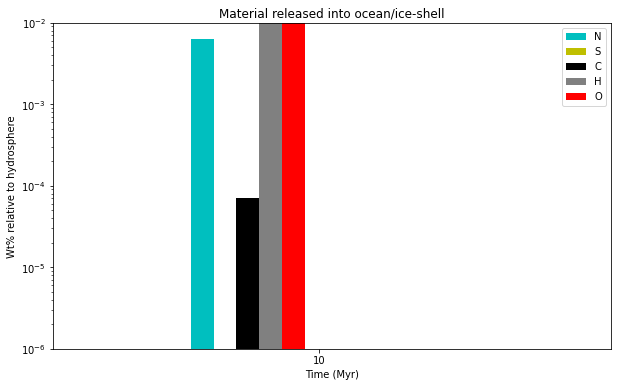

In [12]:
def plot_binned_bar_chart(X, Y, m,lab,col):
    n = len(X)
    # Check if m is valid
    if m >= n:
        raise ValueError("Number of bars (m) must be less than the length of the data (n)")
    # Calculate the bin size
    bin_size = n // m
    # Calculate the bin edges
    bin_edges = np.arange(0, n + bin_size, bin_size)
    # Create an array to store the binned values
    binned_values = np.zeros(m)
    bin_locs = np.zeros(m)
    # Bin the data
    Xlin=np.linspace(X[0],X[-1],len(X))
    for i in range(m):
        start_idx = bin_edges[i]
        end_idx = bin_edges[i + 1] if i < m - 1 else n
        bin_locs[i] = np.mean(Xlin[start_idx:end_idx])
        Xi1=np.argmin(np.abs(X-Xlin[start_idx]))
        Xi2=np.argmin(np.abs(X-Xlin[end_idx-1]))
        binned_values[i] = np.mean(Y[Xi1:Xi2])
    # Plot the binned bar chart
    plt.bar(bin_locs, binned_values, align='center',width=0.05,label=lab,color=col)
    plt.xlabel('Time (Myr)')
    plt.ylabel('Wt% relative to hydrosphere')
    plt.title('Material released into ocean/ice-shell')
    plt.yscale("log")
    #plt.show()

axes=plt.figure(figsize=(10,6))
for j in ["N","S","C","H","O"]:
    Car=np.zeros(maxnt)
    hydroM=np.zeros(maxnt)
    for i in range(0,maxnt):
        if j in Ceres.extracts[i]:
            Car[i]+=Ceres.extracts[i][j]
        for k in range(0,nr):
            hydroM[i]+=(Ceres.grid[i,k].AqMass+Ceres.grid[i,k].IceMass)
            if j in Ceres.grid[i,k].OrgComp:
                Car[i]+=Ceres.grid[i,k].OrgComp[j]
    #plt.plot(Ceres.times/3.154e+7/1e6,Car,label=j)
    logTimes = np.log10(Ceres.times/3.154e+7/1e6)
    offset=0
    col='k'
    mult=2
    if j=="H":
        offset=0.05
        col='grey'
        mult=2
    if j=="O":
        offset=0.1
        col='r'
    if j=="S":
        offset=-0.05
        col="y"
        mult=10
    if j=="N":
        offset=-0.1
        col="c"
    logTimes+=offset
    #plot_binned_bar_chart(logTimes, Car/Ceres.Mass/ICE_frac*100, 10,j,col)
    plot_binned_bar_chart(logTimes, mult*Car/hydroM*100, 10,j,col)

plt.legend()
plt.ylim([10**-6,10**-2])
plt.xticks([1, 2, 3], ['10', '100','1000'])
plt.xlim(np.log10([stime,etime]))
#plt.xscale('log')
#print(Ceres.Mass)

(2.5996702599873176, 43.86010256484523)

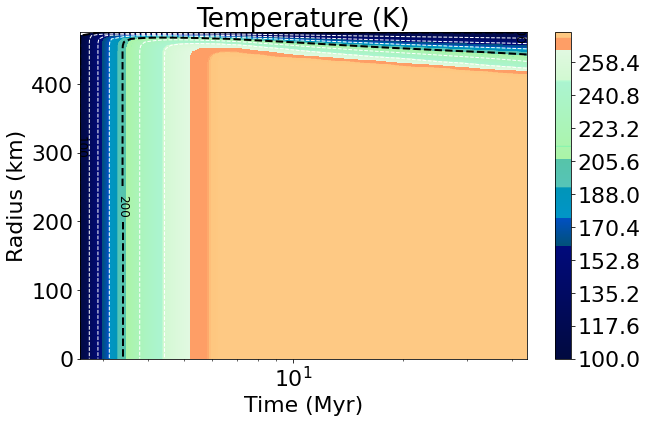

In [13]:
Ceres.plotTemp("Temp","Temperature (K)")
plt.xscale("log")
plt.xlim([stime,etime])
#plt.set_cmap('jet')

In [14]:
tInd = 23
rInd = 0
print(Ceres.grid[tInd,rInd].getIceMass())
print(Ceres.grid[tInd,rInd].getRockMass())
print(Ceres.grid[tInd,rInd].getWaterMass())
print(Ceres.grid[tInd,rInd].Mass)
print(Ceres.grid[tInd,rInd].Celltype)
#print(Ceres.grid[tInd,rInd].RockComp)
#print(Ceres.grid[tInd,rInd].IceComp)

0
764364271365748.9
0
764364271365748.9
3


In [15]:
for i in Ceres.grid[99,44].AqSpec:
    print(i+": "+str(Ceres.grid[99,44].AqSpec[i])+" M")

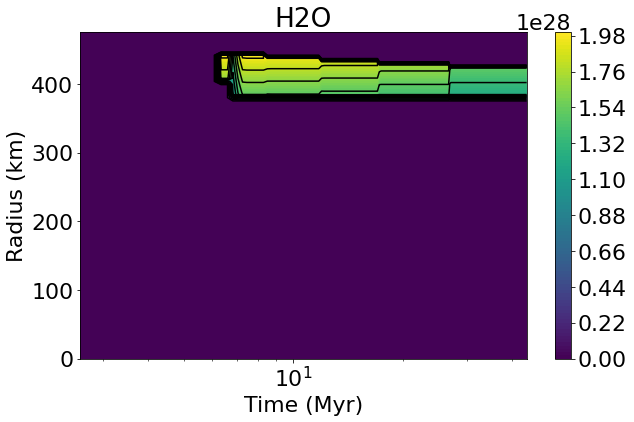

In [16]:
Ceres.plotDictAttribute("AqComp","H2O","H2O",10**9)
plt.xscale("log")

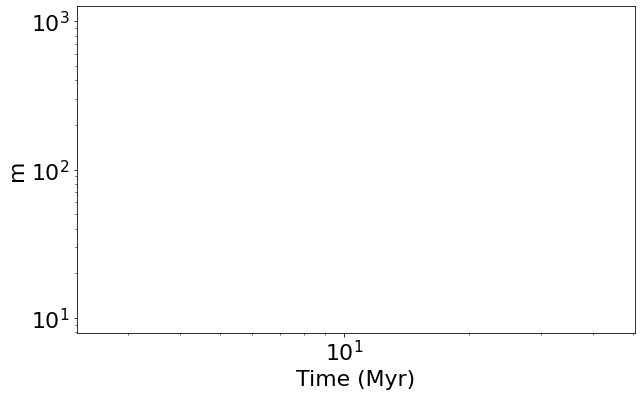

In [17]:
testPlot = Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","m",45,1)
#plt.ylim([10**-2,100])
plt.yscale('log')
plt.xscale('log')

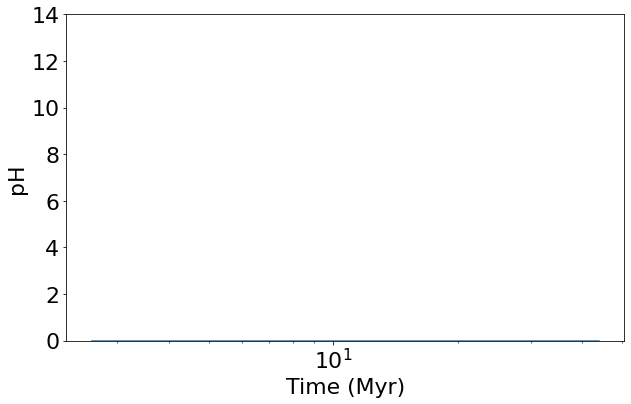

In [18]:
testPlot = Ceres.plotAttributeLine("pH","pH",44)
plt.ylim([0,14])
#plt.yscale('log')
plt.xscale('log')

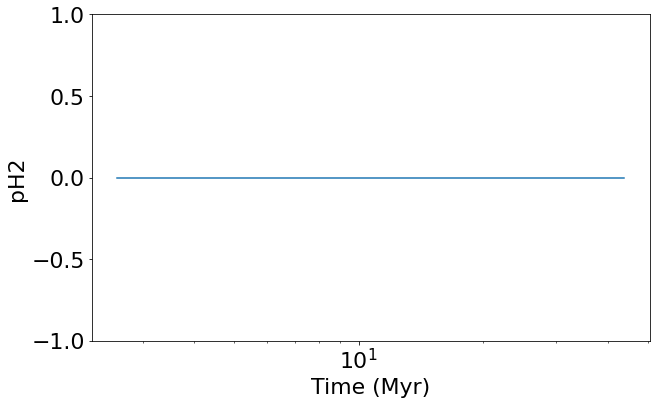

In [19]:
testPlot = Ceres.plotAttributeLine("pH2","pH2",44)
plt.ylim([-1,1])
#plt.yscale('log')
plt.xscale('log')

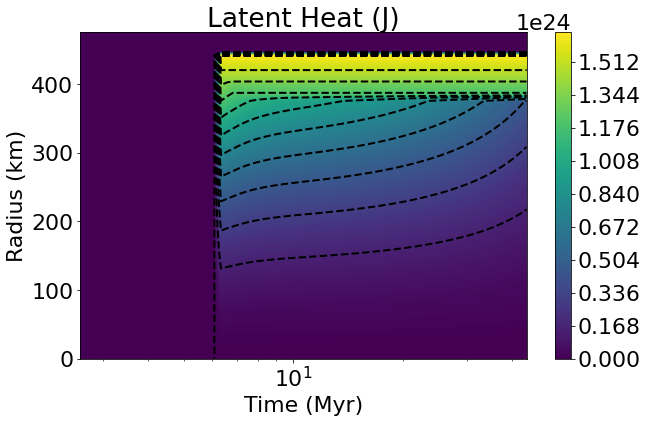

In [20]:
Ceres.plotAttribute("latentHeat","Latent Heat (J)")
plt.xscale("log")

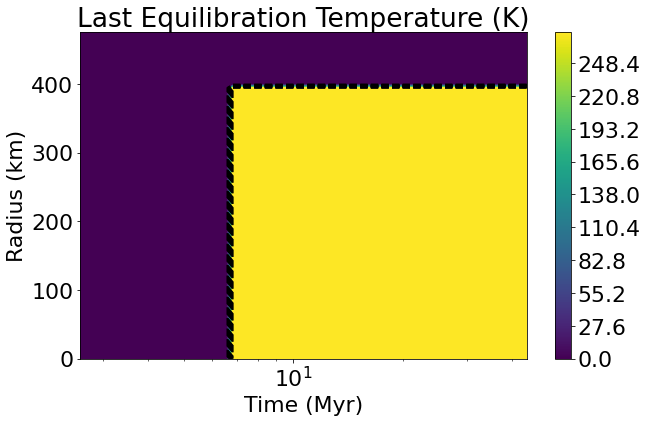

In [21]:
Ceres.plotAttribute("lastEquil","Last Equilibration Temperature (K)")
plt.xscale("log")

gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc

/Users/samuelcourville/Documents/JPL/combinedModel/WOW.py:892: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


(2.5996702599873176, 43.86010256484523)

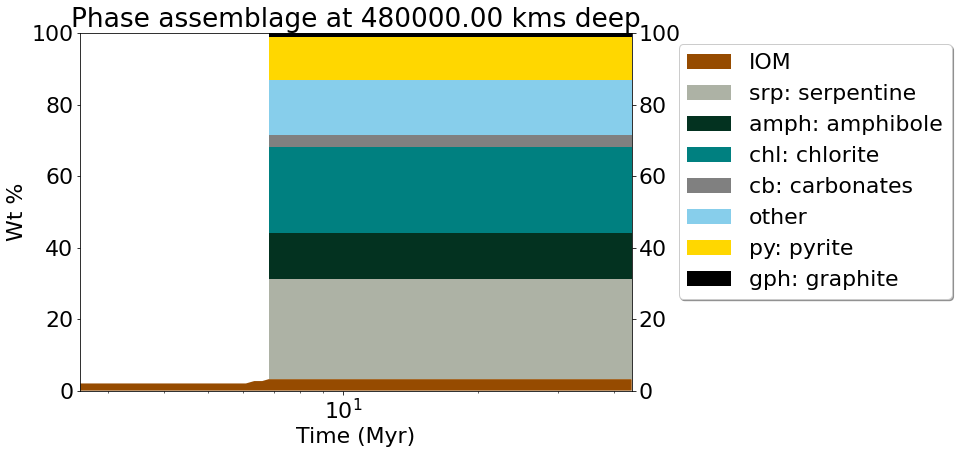

In [22]:
ax = Ceres.plotPhaseAssemblage(0,[])
plt.xscale("log")
plt.xlim([stime,etime])
#plt.legend(bbox_to_anchor=(1.6, 1.0), loc='upper right',
#                   ncol=1, fancybox=True, shadow=True)

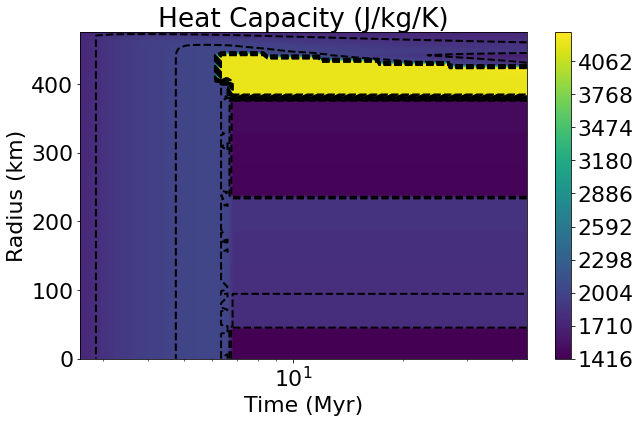

In [23]:
Ceres.plotAttribute("Cp","Heat Capacity (J/kg/K)")
plt.xscale("log")

In [24]:
Ceres.grid[21,92].TCond

0.6000000000000001

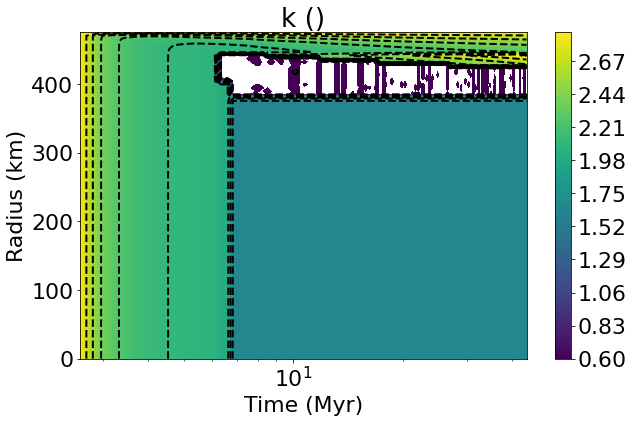

In [25]:
Ceres.plotAttribute("TCond","k ()")
plt.xscale("log")

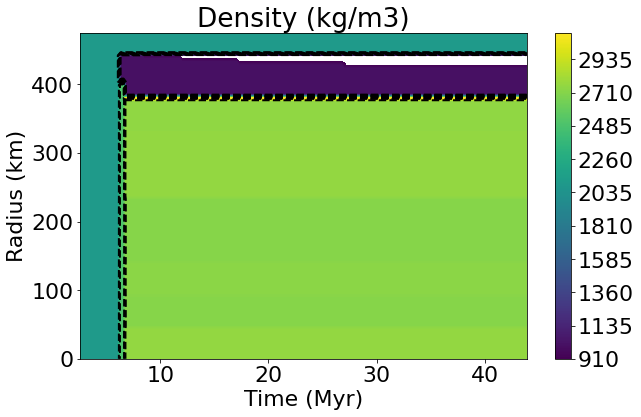

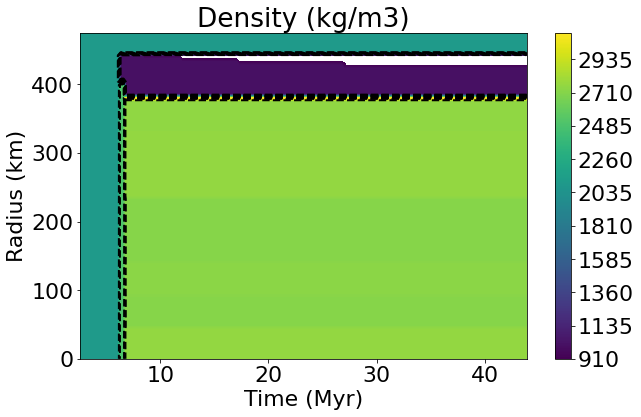

In [26]:
Ceres.plotAttribute("Dens","Density (kg/m3)")

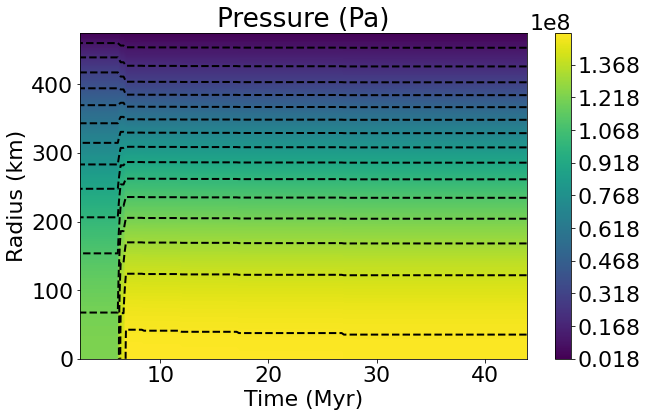

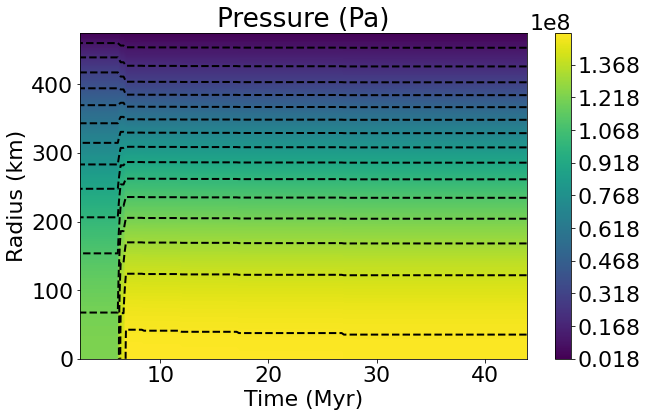

In [27]:
Ceres.plotAttribute("Press","Pressure (Pa)")

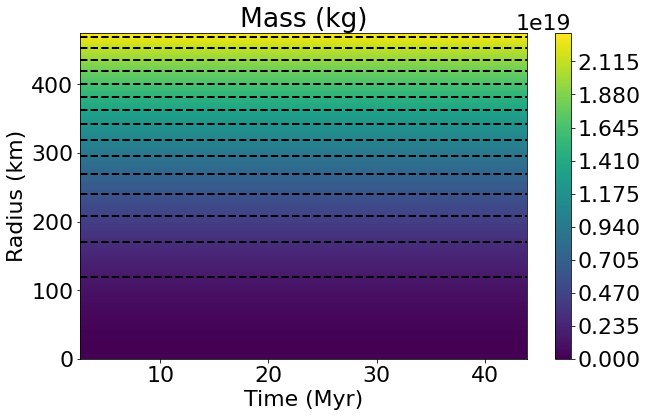

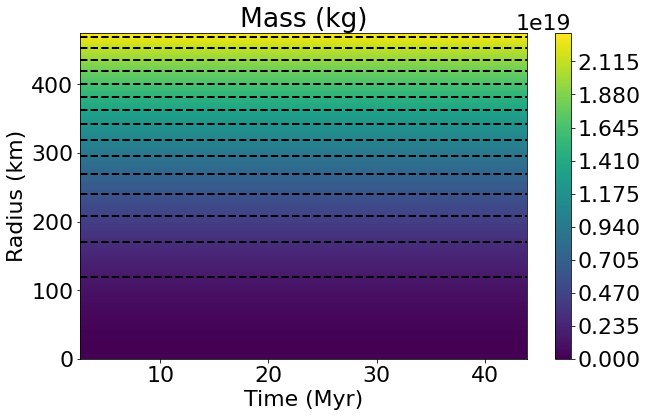

In [28]:
Ceres.plotAttribute("Mass","Mass (kg)")

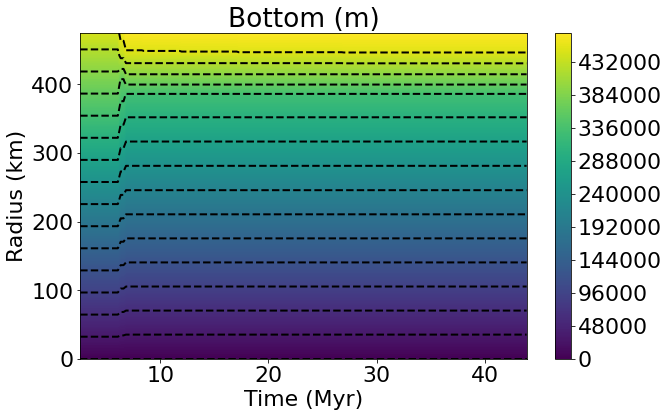

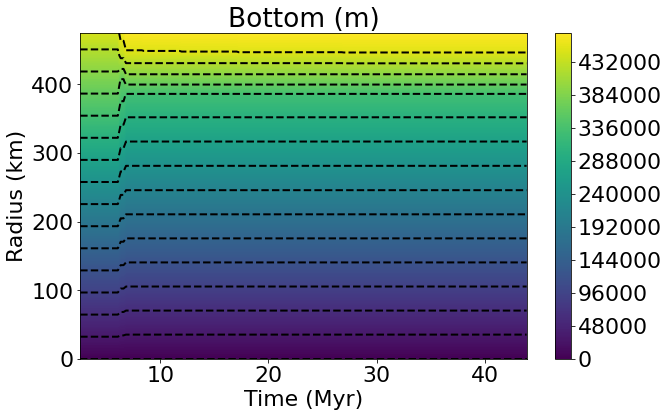

In [29]:
Ceres.plotAttribute("Bot","Bottom (m)")

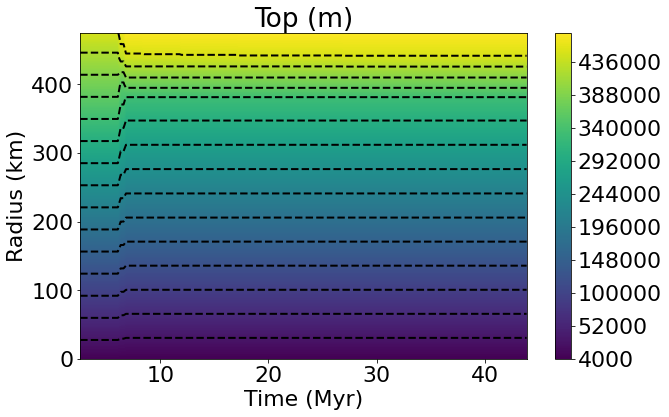

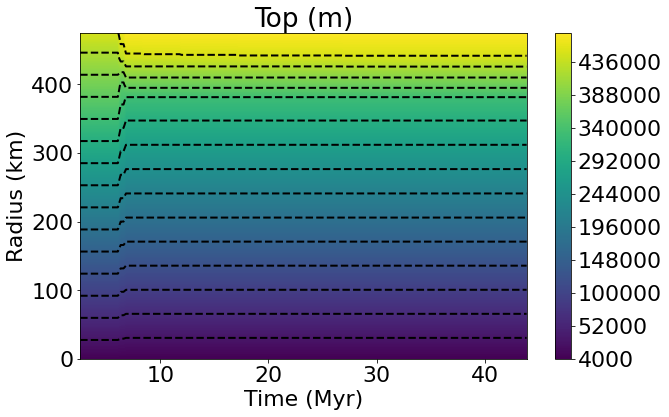

In [30]:
Ceres.plotAttribute("Top","Top (m)")

gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc
gth
cc

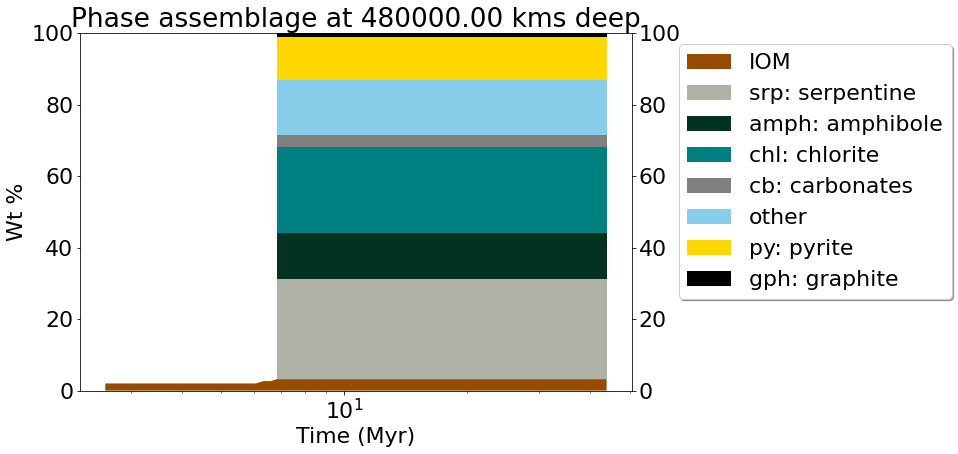

In [31]:
ax = Ceres.plotPhaseAssemblage(0)
plt.xscale("log")

In [32]:
print(Ceres.grid[99,0].RockPhaseDat[1])

{'mass': 11.11, 'wt%': 11.11, 'vol%': 7.67, 'mol%': 0.91, 'mol': 0.012, 'H': 0.218, 'C': 0.0, 'Mg': 0.986, 'Al': 0.0, 'Si': 24.314, 'S': 0.0, 'Ca': 0.0, 'Fe': 27.951, 'O': 41.555, 'Na': 4.976, 'N': 0.0, 'N(g)': 924.06, 'G(J)': -9797862.0, 'S(J/K)': 617.69, 'V(J/bar)': 27.156, 'Cp(J/K)': 656.63, 'Alpha(1/K)': 1.9371e-05, 'Beta(1/bar)': 1.1818e-06, 'Cp/Cv': 1.0036, 'Density(kg/m3)': 3402.7, 'Gruneisen_T': 0.68035, 'Ks(bar)': 849240.0, 'Mu(bar)': 283080.0, 'V0(km/s)': 4.9957, 'Vp(km/s)': 6.0041, 'Vs(km/s)': 2.8843, 'Poisson_ratio': 0.35, 'Enthalpy (J/kg)': 0.0, 'Specific Enthalpy (J/m3)': 0.0, 'Entropy (J/K/kg)': 0.0, 'Specific Entropy (J/K/m3)': 0.0, 'Heat Capacity (J/K/kg)': 0.0, 'Specific Heat Capacity (J/K/m3)': 0.0}


In [33]:
#for i in range(0,1500):
#    if not Ceres.grid[i,1].RockPhaseDat:
#        print(Ceres.grid[i,0].RockPhaseDat)
#        print(i)
        
print(Ceres.grid[99,0].RockPhases)
print(Ceres.grid[99,0].RockPhaseDat[1])

['Atg' 'Amph' 'Chl' 'Do' 'gth' 'cc' 'pyr' 'gph' 'Bulk']
{'mass': 11.11, 'wt%': 11.11, 'vol%': 7.67, 'mol%': 0.91, 'mol': 0.012, 'H': 0.218, 'C': 0.0, 'Mg': 0.986, 'Al': 0.0, 'Si': 24.314, 'S': 0.0, 'Ca': 0.0, 'Fe': 27.951, 'O': 41.555, 'Na': 4.976, 'N': 0.0, 'N(g)': 924.06, 'G(J)': -9797862.0, 'S(J/K)': 617.69, 'V(J/bar)': 27.156, 'Cp(J/K)': 656.63, 'Alpha(1/K)': 1.9371e-05, 'Beta(1/bar)': 1.1818e-06, 'Cp/Cv': 1.0036, 'Density(kg/m3)': 3402.7, 'Gruneisen_T': 0.68035, 'Ks(bar)': 849240.0, 'Mu(bar)': 283080.0, 'V0(km/s)': 4.9957, 'Vp(km/s)': 6.0041, 'Vs(km/s)': 2.8843, 'Poisson_ratio': 0.35, 'Enthalpy (J/kg)': 0.0, 'Specific Enthalpy (J/m3)': 0.0, 'Entropy (J/K/kg)': 0.0, 'Specific Entropy (J/K/m3)': 0.0, 'Heat Capacity (J/K/kg)': 0.0, 'Specific Heat Capacity (J/K/m3)': 0.0}


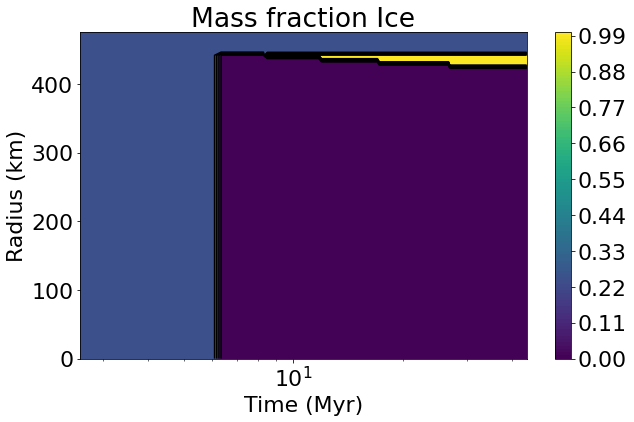

In [34]:
Ceres.plotDictAttributeMassScaled("IceComp","H2O","Mass fraction Ice",0,1)
plt.xscale("log")

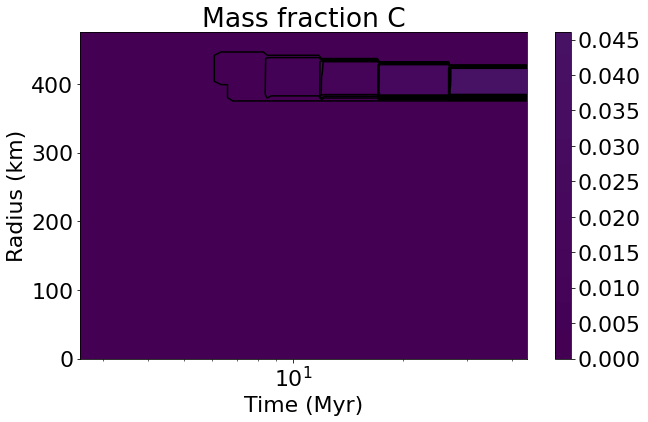

In [35]:
Ceres.plotDictAttributeMassScaled("AqComp","C","Mass fraction C",0,1)
plt.xscale("log")

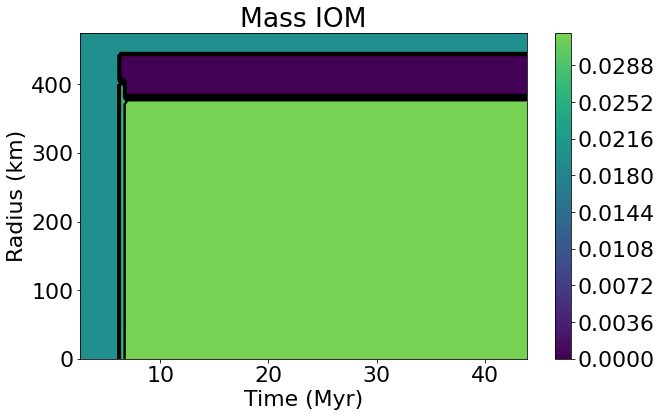

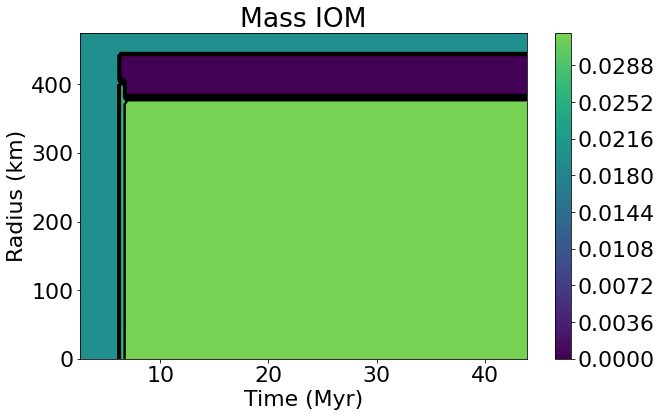

In [36]:
Ceres.plotDictAttributeMassScaled("RockComp","IOM","Mass IOM",0,0.04)

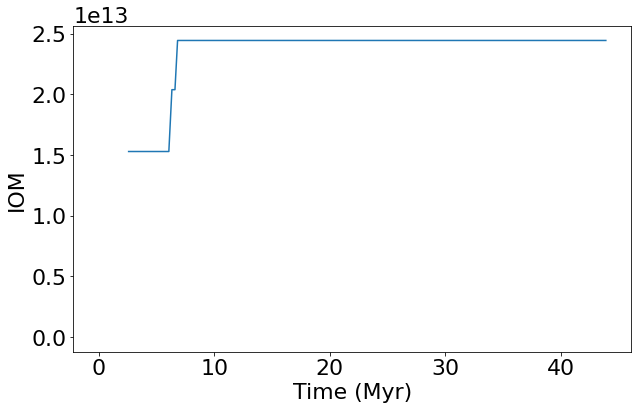

In [37]:
testPlot = Ceres.plotDictAttributeLine("RockComp","IOM","IOM",0)

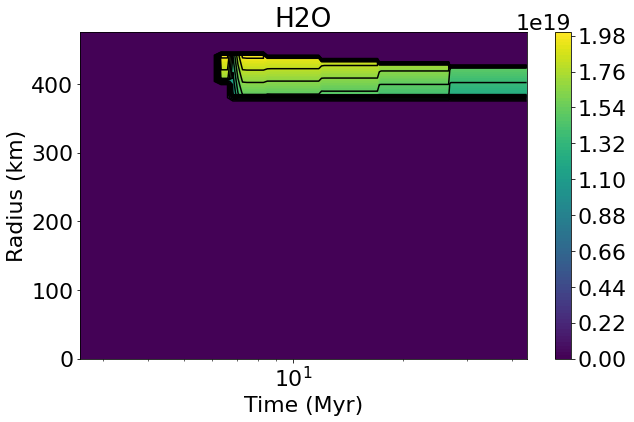

In [38]:
testPlot = Ceres.plotDictAttribute("AqComp","H2O","H2O")
#plt.yscale('log')
plt.xscale('log')

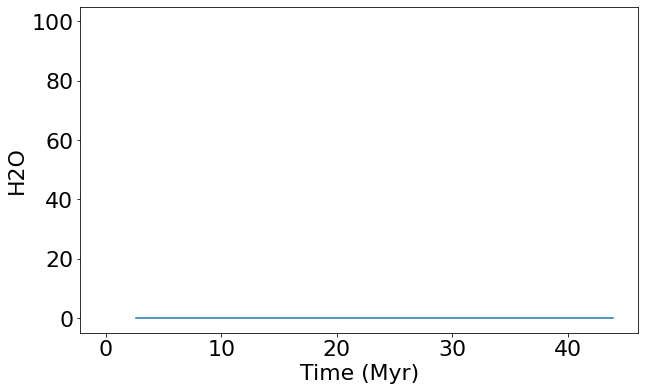

In [39]:
testPlot = Ceres.plotDictAttributeLine("AqComp","CO2","H2O",41)
#plt.ylim([0.6,0.672])
#plt.yscale('log')
#plt.xscale('log')

In [40]:
Ceres.grid[3,45].AqComp

{}

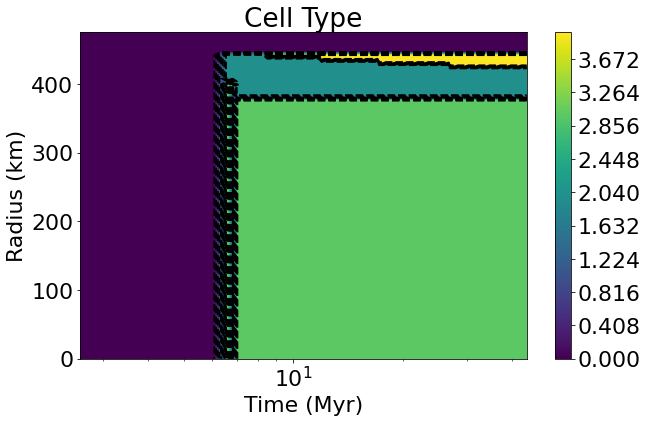

In [41]:
Ceres.plotAttribute("Celltype","Cell Type")
plt.xscale("log")

In [42]:
Ceres.grid[33,0].RockPhases

array(['Atg', 'Amph', 'Chl', 'Do', 'gth', 'cc', 'pyr', 'gph', 'Bulk'],
      dtype='<U7')

In [43]:
Ceres.grid[33,0].RockPhaseDat[3]

{'mass': 2.94,
 'wt%': 2.94,
 'vol%': 2.16,
 'mol%': 1.06,
 'mol': 0.014,
 'H': 0.0,
 'C': 11.448,
 'Mg': 2.243,
 'Al': 0.0,
 'Si': 0.0,
 'S': 0.0,
 'Ca': 19.1,
 'Fe': 21.459,
 'O': 45.749,
 'Na': 0.0,
 'N': 0.0,
 'N(g)': 209.83,
 'G(J)': -1965459.0,
 'S(J/K)': 172.66,
 'V(J/bar)': 6.5563,
 'Cp(J/K)': 154.67,
 'Alpha(1/K)': 3.2929e-05,
 'Beta(1/bar)': 1.0779e-06,
 'Cp/Cv': 1.0118,
 'Density(kg/m3)': 3200.5,
 'Gruneisen_T': 1.3102,
 'Ks(bar)': 938690.0,
 'Mu(bar)': 312900.0,
 'V0(km/s)': 5.4157,
 'Vp(km/s)': 6.5089,
 'Vs(km/s)': 3.1268,
 'Poisson_ratio': 0.35,
 'Enthalpy (J/kg)': 0.0,
 'Specific Enthalpy (J/m3)': 0.0,
 'Entropy (J/K/kg)': 0.0,
 'Specific Entropy (J/K/m3)': 0.0,
 'Heat Capacity (J/K/kg)': 0.0,
 'Specific Heat Capacity (J/K/m3)': 0.0}

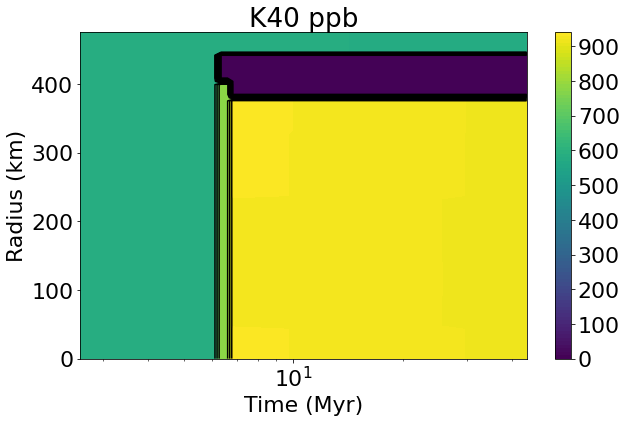

In [44]:
Ceres.plotDictAttribute("RIComp","K40","K40 ppb",10**9)
plt.xscale("log")

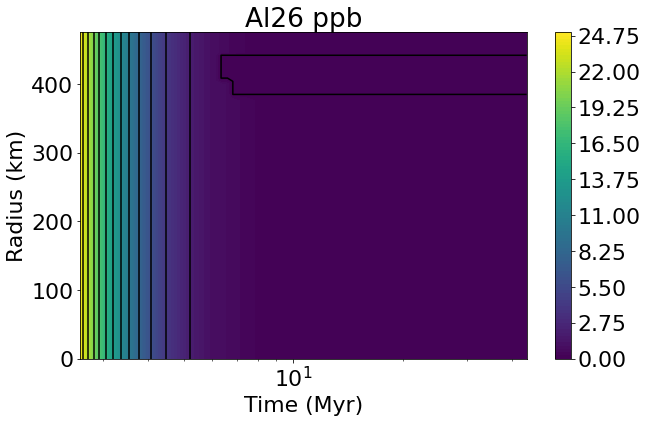

In [45]:
Ceres.plotDictAttribute("RIComp","Al26","Al26 ppb",10**9)
plt.xscale("log")

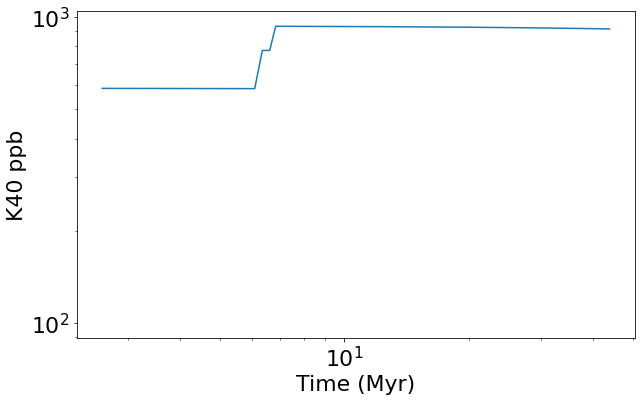

In [46]:
testPlot = Ceres.plotDictAttributeLine("RIComp","K40","K40 ppb",0,10**9)
#plt.xlim([2,12])
plt.yscale('log')
plt.xscale('log')

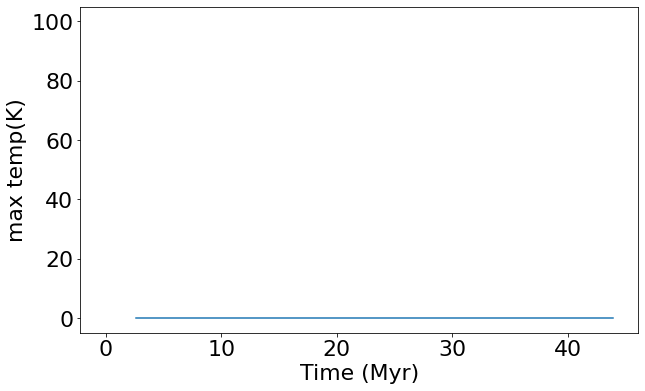

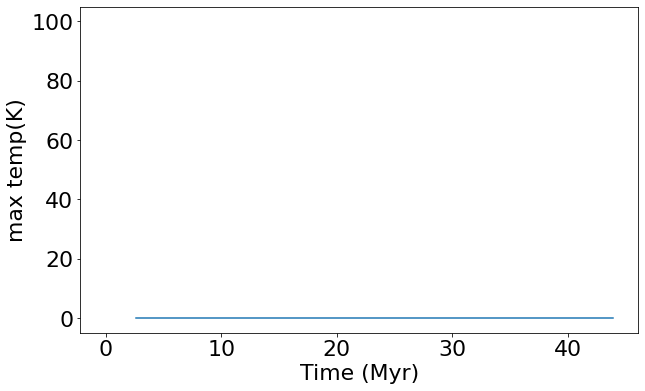

In [47]:
Ceres.plotAttributeLine("MaxOrgTemp","max temp(K)",2)
#plt.xlim([2,12])

<Figure size 432x288 with 0 Axes>

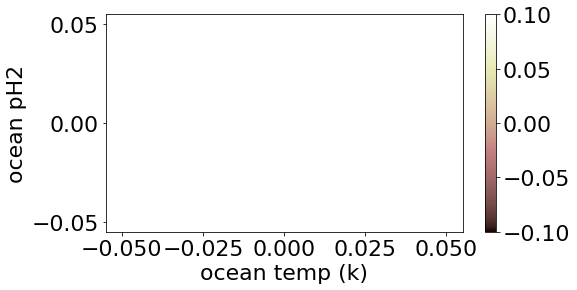

In [48]:
ts = Ceres.times
nt=len(ts)
oceanT=np.zeros(nt)
oceanpH2=np.zeros(nt)
for i in range(0,nt):
    oceanT[i]=Ceres.grid[i,43].Temp
    if "H2(aq)" in Ceres.grid[i,43].AqSpec:
        oceanpH2[i]=-np.log10(Ceres.grid[i,43].AqSpec["H2(aq)"])
    else:
        oceanpH2[i]=np.nan

plt.set_cmap('pink')
plt.figure(figsize=(8,4))
cts=ts/np.max(ts)    
plt.scatter(oceanT,oceanpH2,50,c=cts)
#plt.xlim([200,300])
#plt.ylim([8,10])
#plt.plot(ts,oceanT)

plt.xlabel('ocean temp (k)')
plt.ylabel('ocean pH2')
plt.colorbar()

(0.0, 2000.0)

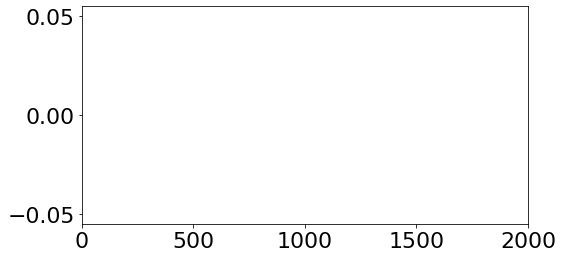

In [49]:

plt.figure(figsize=(8,4)) 
plt.plot(ts[0:-1]*10**-7*10**-6/3.154,np.diff(oceanpH2))
plt.xlim(0,2000)

In [50]:
H=1.0
C=12.01
N=14.01
O=16
Na=22.99
Mg=24.31
Al=26.98
Si=28.09
S=32.07
Cl=35.45
K=39.10
Ca=40.08
Mn=54.94
Fe=55.85
Ni=58.69

In [51]:
#from scipy.special import erf
#
#t=np.linspace(273,1200,100)
#prevOrgT=573
#factSam=0.47
#H2Orel=0.004/factSam*(erf((t-620)/210)+1)
#CO2rel=0.0102/factSam*(erf((t-680)/240)+1)
#CH4rel = 0.0015/factSam*(erf((t-860)/110)+1)#-0.0015/factSam*(erf((prevOrgT-860)/110)+1)
#Cfrac = (12.0/44.0*CO2rel+12.0/16.0*CH4rel)
#Ofrac = (32.0/44.0*CO2rel+16.0/18.0*H2Orel)
#Hfrac = (2.0/18.0*H2Orel+4.0/16.0*CH4rel)
#Mtot=Cfrac+Ofrac+Hfrac
#plt.plot(t,CH4rel)
#plt.plot(t,Mtot)
#Mtot[2]-Mtot[1]